In [114]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

Load data

In [115]:
data = pd.read_csv('data_min_total.csv')
# data_read['DateTime'] = pd.to_datetime(data_read['DateTime'], format='%d/%m/%Y %H:%M')
# data = data_read[data_read['DateTime'] <= '2025-04-30'].copy()

# #data.set_index('Datetime', inplace=True)
# print(data.tail())

Backtesting trading strategy

In [116]:
# Initial conditions
initial_cash = 10000  # Starting cash
cash = initial_cash
shares_owned = 0  # Starting shares owned
transactions = []  # List to record transactions

# Parameters for market impact, slippage, and fees
market_impact_constant = 0.1
average_daily_volume = data['Mid-Price'].count()  # Using total count as a proxy
brokerage_fee_bps = 0.50 / 100
exchange_fee_per_share = 0.000025
shares_per_transaction = 300

# Thresholds
bid_ask_spread_threshold = data['Bid_Ask_Spread'].quantile(0.5)  # Liquidity - median spread as threshold 
order_imbalance_threshold = 0.10  # Volume - placeholder value

# Holding thresholds
volatility_threshold = 0.05  # Placeholder for volatility threshold
proximity_threshold = 0.02  # Placeholder for how close the price should be to the SMA to consider holding

# Simulate using next 10 future prices
look_ahead_window = 10

for i in range(len(data) - look_ahead_window):
    current_mid_price = data.iloc[i]['Mid-Price']
    future_prices = data.iloc[i+1:i+1+look_ahead_window]['Mid-Price']
    future_avg_price = future_prices.mean()
    
    order_imbalance = data.iloc[i]['Order_imbalance']
    bid_ask_spread = data.iloc[i]['Bid_Ask_Spread']
    is_liquid = bid_ask_spread <= bid_ask_spread_threshold and abs(order_imbalance) <= order_imbalance_threshold
    volatility = data.iloc[i]['Historical_Volatility']
    is_hold_condition = (volatility > volatility_threshold)

    # Buy condition based on future price prediction
    if future_avg_price > current_mid_price * 1.05 and is_liquid:
        shares_to_buy = min(shares_per_transaction, int(cash / (current_mid_price + brokerage_fee_bps * current_mid_price + exchange_fee_per_share)))
        shares_to_buy = min(shares_per_transaction, int(cash / (current_mid_price + brokerage_fee_bps * current_mid_price + exchange_fee_per_share)))
        if shares_to_buy > 0:
            volume_ratio = shares_to_buy / average_daily_volume
            price_impact = market_impact_constant * (volume_ratio ** 0.5) * current_mid_price
            adjusted_buy_price = current_mid_price + price_impact
            total_cost = adjusted_buy_price * shares_to_buy + brokerage_fee_bps * adjusted_buy_price * shares_to_buy + exchange_fee_per_share * shares_to_buy
            cash -= total_cost
            shares_owned += shares_to_buy
            transactions.append(('Buy', shares_to_buy, adjusted_buy_price, total_cost, cash, i))
    
    # Sell condition based on future price prediction
    elif future_avg_price < current_mid_price * 0.95 and is_liquid and shares_owned > 0:
        shares_to_sell = min(shares_per_transaction, shares_owned)
        volume_ratio = shares_to_sell / average_daily_volume
        price_impact = market_impact_constant * (volume_ratio ** 0.5) * current_mid_price
        adjusted_sell_price = current_mid_price - price_impact
        total_revenue = adjusted_sell_price * shares_to_sell - brokerage_fee_bps * adjusted_sell_price * shares_to_sell - exchange_fee_per_share * shares_to_sell
        cash += total_revenue
        shares_owned -= shares_to_sell
        transactions.append(('Sell', shares_to_sell, adjusted_sell_price, total_revenue, cash, i))

    # Hold condition remains unchanged
    elif is_hold_condition:
        transactions.append(('Hold', shares_owned, current_mid_price, 0, cash, i))

# Calculate final results
final_valuation = cash + shares_owned * data.iloc[-1]['Mid-Price']

output = {
    "Initial Cash": initial_cash,
    "Final Valuation": final_valuation,
    "Overall Profit/Loss": final_valuation - initial_cash,
    "Number of Transactions": len(transactions),
    "Number of Hold Signals": sum(1 for transaction in transactions if transaction[0] == 'Hold'),
    "Number of Buy Signals": sum(1 for transaction in transactions if transaction[0] == 'Buy'),
    "Number of Sell Signals": sum(1 for transaction in transactions if transaction[0] == 'Sell'),
}

print(output)


{'Initial Cash': 10000, 'Final Valuation': 35274.3256793118, 'Overall Profit/Loss': 25274.325679311798, 'Number of Transactions': 61720, 'Number of Hold Signals': 61661, 'Number of Buy Signals': 30, 'Number of Sell Signals': 29}


Print Results

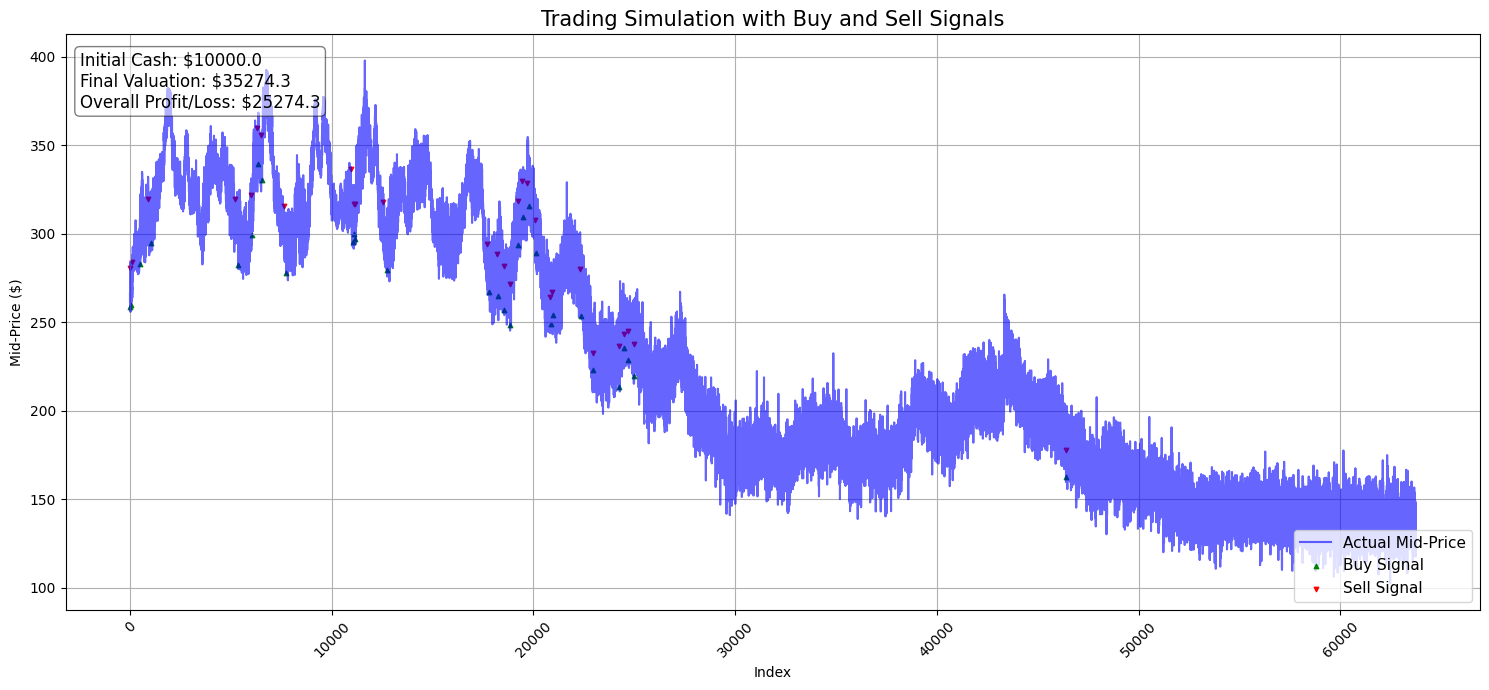

In [117]:
# Convert transactions to a DataFrame
transactions_df = pd.DataFrame(transactions, columns=['Action', 'Shares', 'Price', 'Total Cost', 'Cash After', 'Time'])
# 'Time' in transactions was an index in transactions so map it to an index that data understands
transactions_df['Index'] = transactions_df['Time']

fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(data.index, data['Mid-Price'], label='Actual Mid-Price', color='blue', alpha=0.6)
# Optional = plot SMA Mid-Price
#ax.plot(data.index, data['SMA_Mid_Price'], label='SMA Mid-Price', color='darkorange', alpha=0.8)

# Add buy and sell signals on index points
buy_signals = transactions_df[transactions_df['Action'] == 'Buy']
sell_signals = transactions_df[transactions_df['Action'] == 'Sell']
ax.scatter(buy_signals['Index'], buy_signals['Price'], label='Buy Signal', color='green', marker='^', s=10, alpha=1.0)
ax.scatter(sell_signals['Index'], sell_signals['Price'], label='Sell Signal', color='red', marker='v', s=10, alpha=1.0)

# Add labels with model results
final_valuation = final_valuation  # final calculation from the simulation
initial_cash = initial_cash  # from outputs
text_str = f'Initial Cash: ${initial_cash:.1f}\nFinal Valuation: ${final_valuation:.1f}\nOverall Profit/Loss: ${final_valuation - initial_cash:.1f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# Position the text on the axes
ax.text(0.01, 0.97, text_str, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)

ax.set_title('Trading Simulation with Buy and Sell Signals', fontsize=15)
ax.set_xlabel('Index')
ax.set_ylabel('Mid-Price ($)')
ax.legend(loc='lower right', fontsize=11)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

Not making profit and too few trasnactions

Export the figure

In [118]:
fig.savefig('Trading Simulation ARIMA1 Results Rolling.png', dpi=600, bbox_inches='tight')

Other assessment parameters

In [119]:
def calculate_sortino_ratio(daily_returns, risk_free_rate=0.01):
    negative_returns = daily_returns[daily_returns < 0]
    downside_deviation = np.std(negative_returns, ddof=1)
    excess_daily_returns = daily_returns - risk_free_rate / 365
    sortino_ratio = np.mean(excess_daily_returns) / downside_deviation
    return sortino_ratio * np.sqrt(252)  # Annualize

def calculate_sharpe_ratio(daily_returns, risk_free_rate=0.01):
    excess_daily_returns = daily_returns - risk_free_rate / 365
    sharpe_ratio = np.mean(excess_daily_returns) / np.std(excess_daily_returns, ddof=1)
    return sharpe_ratio * np.sqrt(252)  # Annualize

def calculate_maximum_drawdown(cumulative_returns):
    # Ensure cumulative_returns is not empty
    if len(cumulative_returns) > 0:
        running_max = np.maximum.accumulate(cumulative_returns)
        # Avoid division by zero by ensuring running_max is always greater than zero
        running_max_nonzero = np.where(running_max == 0, np.nan, running_max)
        drawdown = (running_max_nonzero - cumulative_returns) / running_max_nonzero
        max_drawdown = np.nanmax(drawdown)  # Drawdowns are negative values
        return -max_drawdown if not np.isnan(max_drawdown) else 0  # Return positive value for max drawdown
    else:
        return 0  # Return 0 if there's no variation or data is empty

def calculate_calmar_ratio(annual_return, max_drawdown):
    # Assuming max_drawdown is negative, make it positive for the ratio
    return annual_return / abs(max_drawdown)

Reload data as data is edited

In [120]:
data = pd.read_csv('data_min_total.csv')
# data_read['DateTime'] = pd.to_datetime(data_read['DateTime'], format='%d/%m/%Y %H:%M')
# data = data_read[data_read['DateTime'] <= '2025-04-30'].copy()

#data.set_index('Datetime', inplace=True)
#print(data.tail())

Parameter optimisation

In [121]:
# Assuming 'data' is already loaded as a DataFrame

def run_trading_simulation(future_buy_increase, future_sell_decrease, bid_ask_spread_threshold, order_imbalance_threshold, volatility_threshold, proximity_threshold):
    # Initial conditions
    initial_cash = 20000  # Starting cash
    cash = initial_cash
    shares_owned = 0  # Starting shares owned
    transactions = []  # List to record transactions
    daily_portfolio_values = []  # Track daily portfolio values for performance metrics calculation

    # Parameters for market impact, slippage, and fees
    market_impact_constant = 0.1
    average_daily_volume = data['Mid-Price'].count()  # Using total count as a proxy
    brokerage_fee_bps = 0.50 / 100
    exchange_fee_per_share = 0.000025
    shares_per_transaction = 500

    look_ahead_window = 10
  
    for i in range(len(data) - look_ahead_window):  # 10-day look ahead
        current_mid_price = data.iloc[i]['Mid-Price']
        future_prices = data.iloc[i+1:i+11]['Mid-Price']
        future_avg_price = future_prices.mean()

        order_imbalance = data.iloc[i]['Order_imbalance']
        bid_ask_spread = data.iloc[i]['Bid_Ask_Spread']
        is_liquid = bid_ask_spread <= bid_ask_spread_threshold and abs(order_imbalance) <= order_imbalance_threshold
        price_proximity = abs(current_mid_price - future_avg_price) / current_mid_price
        volatility = data.iloc[i]['Historical_Volatility']
        is_hold_condition = (price_proximity < proximity_threshold or volatility > volatility_threshold)

        if future_avg_price > current_mid_price * future_buy_increase and is_liquid and cash > 0:
            # Buy condition
            shares_to_buy = min(shares_per_transaction, int(cash / (current_mid_price + brokerage_fee_bps * current_mid_price + exchange_fee_per_share)))
            volume_ratio = (shares_to_buy) / average_daily_volume
            price_impact = market_impact_constant * (volume_ratio ** 0.5) * current_mid_price
            adjusted_buy_price = current_mid_price + price_impact
            total_cost = adjusted_buy_price * shares_to_buy + brokerage_fee_bps * adjusted_buy_price * shares_to_buy + exchange_fee_per_share * shares_to_buy
            cash -= total_cost
            shares_owned += shares_to_buy
            transactions.append(('Buy', shares_to_buy, adjusted_buy_price, total_cost, cash, i))

        elif future_avg_price < current_mid_price * future_sell_decrease and is_liquid and shares_owned > 0:
            # Sell condition
            shares_to_sell = min(shares_per_transaction, shares_owned)
            volume_ratio = shares_to_sell / average_daily_volume
            price_impact = market_impact_constant * (volume_ratio ** 0.5) * current_mid_price
            adjusted_sell_price = current_mid_price - price_impact
            total_revenue = adjusted_sell_price * shares_to_sell - brokerage_fee_bps * adjusted_sell_price * shares_to_sell - exchange_fee_per_share * shares_to_sell
            cash += total_revenue
            transactions.append(('Sell', shares_to_sell, adjusted_sell_price, total_revenue, cash, i))
            shares_owned = 0

        # Hold condition
        elif is_hold_condition:
            # Log hold action only if conditions suggest increased risk or uncertainty
            transactions.append(('Hold', shares_owned, current_mid_price, 0, cash, i))

        # Update the portfolio value for each day
        portfolio_value = cash + shares_owned * current_mid_price
        daily_portfolio_values.append(portfolio_value)
    
    # Calculate daily returns from portfolio values
    daily_returns = pd.Series(daily_portfolio_values).pct_change().dropna()
    
    # Performance Metrics
    sortino_ratio = calculate_sortino_ratio(daily_returns)
    sharpe_ratio = calculate_sharpe_ratio(daily_returns)
    cumulative_returns = (1 + daily_returns).cumprod() - 1
    max_drawdown = calculate_maximum_drawdown(cumulative_returns)
    if len(data) > 0 and (cumulative_returns.iloc[-1] + 1) > 0:
        annual_return = (cumulative_returns.iloc[-1] + 1) ** (365 / len(data)) - 1
    else:
        # Handle cases where annual return cannot be computed traditionally
        annual_return = None  # Or other appropriate handling
    calmar_ratio = calculate_calmar_ratio(annual_return, max_drawdown)
    
    # Return the overall profit or loss for this simulation run
    final_valuation = cash + shares_owned * data.iloc[-1]['Mid-Price']
    return final_valuation - initial_cash, transactions, sortino_ratio, sharpe_ratio, max_drawdown, calmar_ratio, daily_returns

# Define parameter ranges
future_buy_increases = [1.03, 1.05, 1.07]
future_sell_decreases = [0.97, 0.95, 0.93]
bid_ask_spread_thresholds = [data['Bid_Ask_Spread'].quantile(q) for q in [0.45, 0.5, 0.55]]
order_imbalance_thresholds = [0.08, 0.10, 0.12]
volatility_thresholds = [0.04, 0.05, 0.06]
proximity_thresholds = [0.01, 0.02, 0.03]

results = []

# Nested loops for parameter testing
for future_buy_increase in future_buy_increases:
    for future_sell_decrease in future_sell_decreases:
        for bid_ask_spread_threshold in bid_ask_spread_thresholds:
            for order_imbalance_threshold in order_imbalance_thresholds:
                for volatility_threshold in volatility_thresholds:
                    for proximity_threshold in proximity_thresholds:
                        profit_loss, transactions, sortino_ratio, sharpe_ratio, max_drawdown, calmar_ratio, daily_returns = run_trading_simulation(
                            future_buy_increase,
                            future_sell_decrease,
                            bid_ask_spread_threshold,
                            order_imbalance_threshold,
                            volatility_threshold,
                            proximity_threshold
                        )
                        results.append((future_buy_increase, future_sell_decrease, bid_ask_spread_threshold, order_imbalance_threshold, volatility_threshold, proximity_threshold, profit_loss, len(transactions), sortino_ratio, sharpe_ratio, max_drawdown, calmar_ratio))

# Output results
results_df = pd.DataFrame(results, columns=['Future Buy Increase', 'Future Sell Decrease', 'Bid Ask Spread Threshold', 'Order Imbalance Threshold', 'Volatility Threshold', 'Proximity Threshold', 'Profit/Loss', 'Number of Transactions', 'Sortino Ratio', 'Sharpe Ratio', 'Max Drawdown', 'Calmar Ratio'])
print(results_df.head(50))
results_df.to_csv('trading_simulation_results.csv')

    Future Buy Increase  Future Sell Decrease  Bid Ask Spread Threshold  \
0                  1.03                  0.97                    39.882   
1                  1.03                  0.97                    39.882   
2                  1.03                  0.97                    39.882   
3                  1.03                  0.97                    39.882   
4                  1.03                  0.97                    39.882   
5                  1.03                  0.97                    39.882   
6                  1.03                  0.97                    39.882   
7                  1.03                  0.97                    39.882   
8                  1.03                  0.97                    39.882   
9                  1.03                  0.97                    39.882   
10                 1.03                  0.97                    39.882   
11                 1.03                  0.97                    39.882   
12                 1.03  

In [122]:

# Check for NaN values in the DataFrame
nan_values = data.isna().sum()

# Print the count of NaN values for each column
print("NaN values count per column:")
print(nan_values)

# Print the rows with NaN values
nan_rows = data[data.isna().any(axis=1)]
print("\nRows containing NaN values:")
print(nan_rows)

NaN values count per column:
DateTime_Minute                   0
Bid1_Price                        0
Bid1_Volume                       0
Ask1_Price                        0
Ask1_Volume                       0
Bid2_Price                        0
Bid2_Volume                       0
Ask2_Price                        0
Ask2_Volume                       0
Mid-Price                         0
Bid_Ask_Spread                    0
Market_Depth_Bid                  0
Market_Depth_Ask                  0
Historical_Volatility             0
Total_volume                      0
Cumulative_Volume_Difference      0
Total_Volume_Change_Corrected     0
Order_imbalance                   0
Opening_Price                     1
Closing_Price                     1
Lowest_Price                      1
Highest_Price                     1
Trade_Volume                      0
Price_Mean                        3
RSI                              13
MACD                              0
MACD_signal                       0

In [123]:
print("cash:", cash)
print("current_mid_price:", current_mid_price)
print("brokerage_fee_bps:", brokerage_fee_bps)
print("exchange_fee_per_share:", exchange_fee_per_share)

print("Shares per transaction:", shares_per_transaction)
print("Cash:", cash)
print("Current mid price:", current_mid_price)
print("Brokerage fee bps:", brokerage_fee_bps)
print("Exchange fee per share:", exchange_fee_per_share)

cash: -238.35432068820228
current_mid_price: 123.68
brokerage_fee_bps: 0.005
exchange_fee_per_share: 2.5e-05
Shares per transaction: 300
Cash: -238.35432068820228
Current mid price: 123.68
Brokerage fee bps: 0.005
Exchange fee per share: 2.5e-05


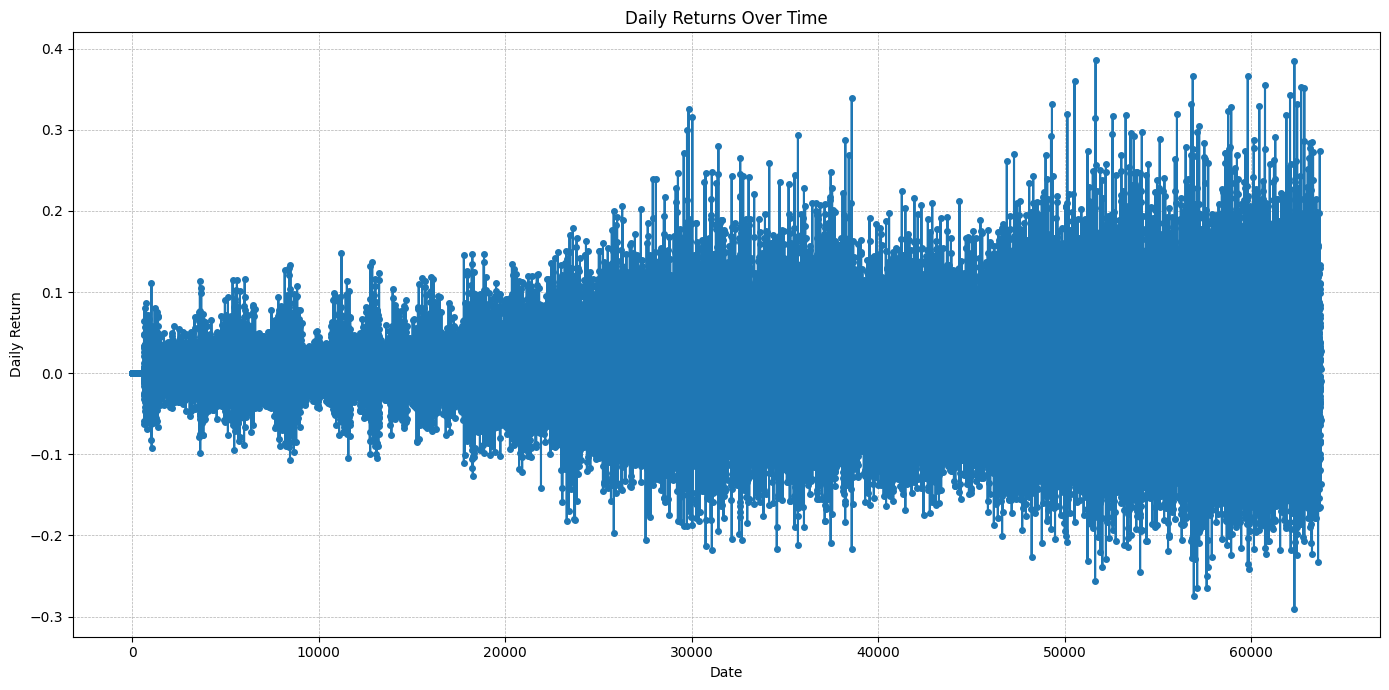

In [124]:
import matplotlib.pyplot as plt

# Assuming daily_returns is a pandas Series containing your daily return values
plt.figure(figsize=(14, 7))  # Set the figure size for better readability
plt.plot(daily_returns, marker='o', linestyle='-', markersize=4)
plt.title('Daily Returns Over Time')  # Title of the plot
plt.xlabel('Date')  # X-axis label
plt.ylabel('Daily Return')  # Y-axis label
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add grid for easier readability
plt.tight_layout()  # Adjust the layout to make room for the plot labels

# If the index of daily_returns is not already a datetime index, you might want to convert it for better x-axis labels
# daily_returns.index = pd.to_datetime(daily_returns.index)

plt.show()